# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj2/" 

utilfn = datadir + "utils.py"
# !cp "$utilfn" .
samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .
import utils

In [8]:
from utils import cut # default cut function for seam finding section

In [9]:
# MY HELPERS
from random import randint
def showImg(img):
    if isinstance(img, list):
        fig, axes = plt.subplots(1, len(img))
        for i in range(len(img)):
            axes[i].imshow(img[i], cmap='gray')
            axes[i].set_title('Image ' + str(i)), axes[i].set_xticks([]), axes[i].set_yticks([])
        return axes
    
    else:
        fig = plt.figure()
        plt.imshow(img, cmap='gray')
        plt.axis('off')

def label(axes, labels):
    for i in range(len(labels)):
        axes[i].set_title(labels[i])

### Part I: Randomly Sampled Texture (10 pts)

In [10]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros([out_size, out_size, 3]).astype(int) # empty output
    
    for x in range(0, out_size, patch_size): # loop through patches
        for y in range(0, out_size, patch_size):
            if x+patch_size < out_size and y+patch_size < out_size: # if patch will go out of bounds, continue
                xOrg = randint(0, xRange) # randomly sample cords within viable range
                yOrg = randint(0, yRange)
                randSamp = sample[xOrg:xOrg+patch_size, yOrg:yOrg+patch_size, :] # use cords to sample patch from original image
                outImg[x:x+patch_size, y:y+patch_size, :] = randSamp # apply patch to output image
    return outImg

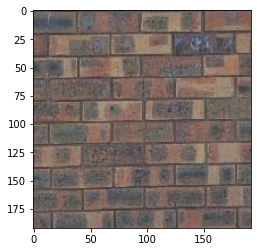

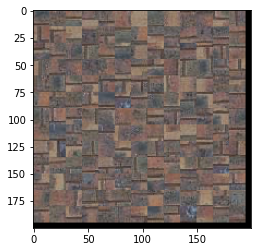

In [11]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [59]:
def ssd_patch(T, I): # patch to fill, original sample image
    M = T.flatten() # copy T into M and flatten to iterate
    for i in range(len(M)): # truncate anything above 0 to 1
        if M[i] > 0:
            M[i] = 1
            
    
    M = M.reshape(T.shape) # reshape M to match T
        
    M = M.astype(float) # type cast for ssd
    T = T.astype(float)
    I = I.astype(float)
    
    ssd = ( ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M) )  
    
    ssd = np.mean(ssd, axis=2) # avarage 3 channels
    return ssd

def getPatch(sample, center, patchLen): # original image, center pixel cords,
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size 
    xCorner = int(center[0] - patchLen/2)+1  # get corner pixels (center - half patch length and +1 to round up)
    yCorner = int(center[1] - patchLen/2)+1
    if xCorner < 0 or yCorner < 0 or xCorner+patchLen >= xRange or yCorner+patchLen >= yRange: # if corners out of range, return nothing
        return []
    outPatch = sample[xCorner:xCorner+patch_size, yCorner:yCorner+patch_size, :].copy() # else return patch from sample
    return outPatch
    
    
def choose_sample(ssdPatch, tol, patch_size, sample): # ssd matrix, tolerance, patch size, original image    
    sortedSSD = np.argsort(ssdPatch, axis=None) # sort ssd matrix and collapse into 1 dimension
    randIdx = randint(0, tol) # randomly choose low ssd center pixel within tol
    outPatch = [] # init empty output patch
    while len(outPatch) == 0: # while the chosen patch is invalid
        flattenedCenter = sortedSSD[randIdx] # get 1d center cord
        cords = np.unravel_index(flattenedCenter, ssdPatch.shape) # convert 1d cord to 2d cord
        outPatch = getPatch(sample, cords, patch_size) # sample patch from image
        randIdx += 1 # if the patch is invalid, move to next lowest pixel in ssd

    return outPatch
    
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros([out_size, out_size, 3]).astype(int) # init empty output

    for x in range(0, out_size, patch_size-overlap): # iterate through patches
        for y in range(0, out_size, patch_size-overlap):
            if x == 0 and y == 0: # first patch
                xOrg = randint(0, xRange) # randomly sample within range
                yOrg = randint(0, yRange)
                randSamp = sample[xOrg:xOrg+patch_size, yOrg:yOrg+patch_size, :] # sample patch from original image
                outImg[x:x+patch_size, y:y+patch_size, :] = randSamp # apply patch to output
                
            else: # not first patch
                if x+patch_size < out_size and y+patch_size < out_size: # if patch doesnt overlap out of bounds
                    ssdPatch = ssd_patch(outImg[x:x+patch_size, y:y+patch_size, :], sample[:,:,:]) # get ssd matrix
                    goodSample = choose_sample(ssdPatch, tol, patch_size, sample) # choose good sample from ssd matrix
                    outImg[x:x+patch_size, y:y+patch_size, :] = goodSample # apply good patch to output
           
    return outImg

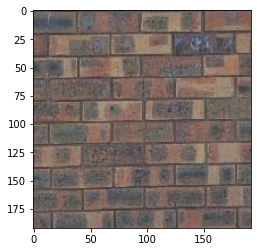

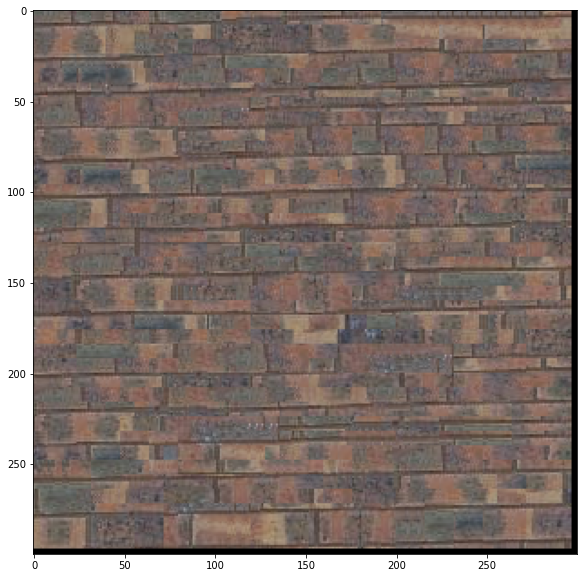

In [75]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 17
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [100]:
def path_ssd(patch1, patch2): # two images to be spliced
    ssdPatch = patch1 - patch2 # ssd of two images overlayed
    ssdPatch = ssdPatch **2
    return ssdPatch

def quilt_cut(sample, out_size, patch_size, overlap, tol, display_cuts): 
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    added display_cuts to toggle whether cuts are displayed
    :return: numpy.ndarray
    """
    
    # setup
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros([out_size, out_size, 3]).astype(int) # init empty output
    
    # random position to display cut
    xDisplay = randint(0, xRange)
    yDisplay = randint(0, xRange)
    
    # iterate
    for x in range(0, out_size, patch_size-overlap): # iterate through patches
        for y in range(0, out_size, patch_size-overlap):
            if x == 0 and y == 0: # first patch
                xOrg = randint(1, xRange) # randomly sample within the middle
                yOrg = randint(1, yRange)
                randSamp = sample[xOrg:xOrg+patch_size, yOrg:yOrg+patch_size, :] # sample patch from original image
                outImg[x:x+patch_size, y:y+patch_size, :] = randSamp # apply patch to output
            else: # not first patch
                if x+patch_size < out_size and y+patch_size < out_size: # if patch doesnt overlap out of bounds
                    outPatch = outImg[x:x+patch_size, y:y+patch_size, :]
                    ssdPatch = ssd_patch(outPatch, sample[:,:,:]) # get ssd matrix
                    goodSample = choose_sample(ssdPatch, tol, patch_size, sample) # choose good sample from ssd matrix
            
                    # cutting
                    ssdPath = []
                    if y > 0 and x > 0: # if within image, cut vertically and horizontally
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)))
                        ssdPath = ssdPath * cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T # mask the mask
                    elif y == 0: # if on x axis, only cut vertically (horizontal in display image)
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2))) 
                    elif x == 0: # if on y axis, only cut horixontally (vertical in display image)
                        ssdPath = cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T
                    
                    #display ssd and cut masks
                    if x >= xDisplay and y >= yDisplay and display_cuts:
                        ssdDisplay = path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2))
                        vertCut = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)))
                        horCut = cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T
                        comboCut = vertCut*horCut
                        showImg(np.sqrt(ssdDisplay).astype(int)) # scale values with sqrt then cast to int to display
                        axes = showImg([vertCut, horCut, comboCut])
                        label(axes, ["Vertical Cut", "Horizontal Cut", "Combined Cut"])
                    
                    # apply mask
                    for i in range(goodSample.shape[2]): # mask all 3 RGB channels
                        goodSample[:,:,i] = goodSample[:,:,i] * ssdPath # apply mask to new patch
                        outPatch[:,:,i] = outPatch[:,:,i] * np.absolute(ssdPath-1) # apply inverted mask to existing patch
                    
                    # display patches
                    if x >= xDisplay and y >= yDisplay and display_cuts:                        
                        axes = showImg([goodSample, outPatch])
                        label(axes, ["New Patch", "Old Patch"])
                        display_cuts = False
                    
                    # combine patches and apply
                    goodSample = goodSample + outPatch # overlay patches
                    outImg[x:x+patch_size, y:y+patch_size, :] = goodSample # apply cut patch to output
           
    return outImg

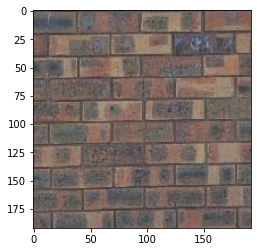

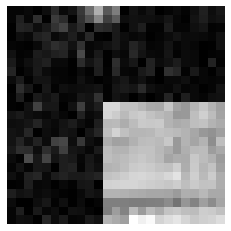

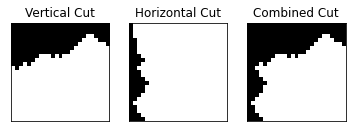

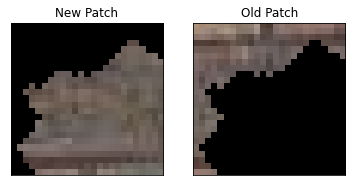

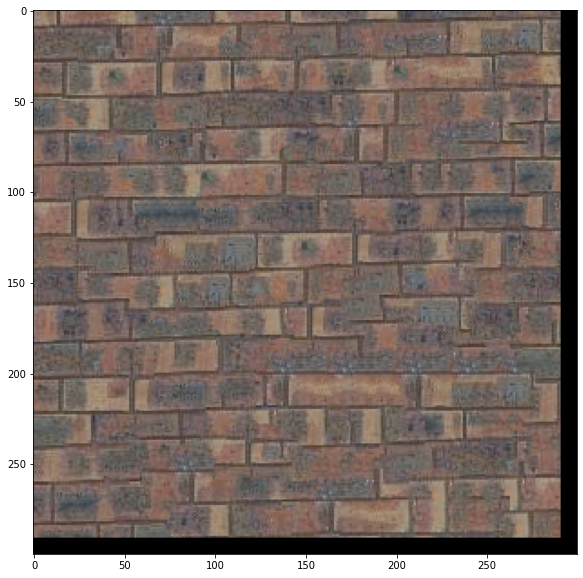

In [103]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol, True)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

array([<AxesSubplot:title={'center':'Image 0'}>,
       <AxesSubplot:title={'center':'Image 1'}>], dtype=object)

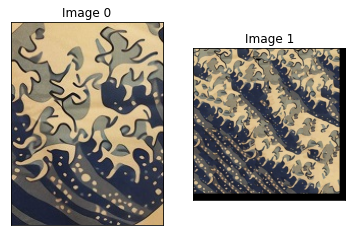

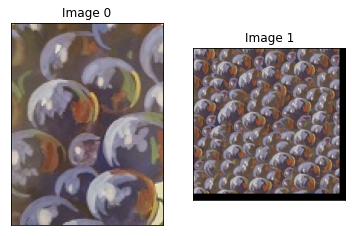

In [111]:
# MY PICTURES
sample_backpack = 'samples/wave_texture.jpg' 
sample_backpack_img = cv2.cvtColor(cv2.imread(sample_backpack), cv2.COLOR_BGR2RGB)
sample_ground = 'samples/grapes.jpg' 
sample_ground_img = cv2.cvtColor(cv2.imread(sample_ground), cv2.COLOR_BGR2RGB)

# paramaters
out_size = sample_backpack_img.shape[0]+sample_ground_img.shape[0] # combined size to ensure output is larger
patch_size = 25
overlap = 11
tol = 5

backpack_res = quilt_cut(sample_backpack_img, out_size, patch_size, overlap, tol, False)
ground_res = quilt_cut(sample_ground_img, out_size, patch_size, overlap, tol, False)

showImg([sample_backpack_img, backpack_res])
showImg([sample_ground_img, ground_res])

### part IV: Texture Transfer (30 pts)

In [118]:
def gray_scale(img): # grayscale helper
    img = np.float32(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def transfer_ssd(T, I, guidePatch, alpha): # patch to fill, original sample image
    T = gray_scale(T)
    I = gray_scale(I)
    guidePatch = gray_scale(guidePatch)
    
    M = T.flatten() # copy T into M and flatten to iterate
    for i in range(len(M)): # truncate anything above 0 to 1
        if M[i] > 0:
            M[i] = 1
            
    
    M = M.reshape(T.shape) # reshape M to match T
        
    M = M.astype(float) # type cast for ssd
    T = T.astype(float)
    I = I.astype(float)
    guidePatch = guidePatch.astype(float)
    unit = np.ones(M.shape).astype(float)
    
    #ssd for patch and coresponding guide 
    ssd_patch = ( ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M) )
    ssd_guide = ( ((unit*guidePatch)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = unit*guidePatch) + cv2.filter2D(I ** 2, ddepth=-1, kernel=unit) )
    
    # combine ssd
    ssd_combo = ssd_patch*alpha + ssd_guide*(1-alpha)    

    return ssd_combo


def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
#     guidance_im = cv2.GaussianBlur(guidance_im, (31, 31), 5) # blur guidance_im
    
    # setup
    xRange = sample.shape[0]-patch_size # set max index for x and y values
    yRange = sample.shape[1]-patch_size
    outImg = np.zeros(guidance_im.shape).astype(int) # init empty output
    
    out_width = guidance_im.shape[0] 
    out_height = guidance_im.shape[1] 
    
    # iterate
    for x in range(0, out_width, patch_size-overlap): # iterate through patches
        for y in range(0, out_height, patch_size-overlap):
            if x+patch_size < out_width and y+patch_size < out_height: # if patch doesnt overlap out of bounds
                outPatch = outImg[x:x+patch_size, y:y+patch_size, :].copy()
                guidePatch = guidance_im[x:x+patch_size, y:y+patch_size, :].copy()
                
                ssdPatch = transfer_ssd(outPatch, sample[:,:,:], guidePatch, alpha) # get ssd matrix

                goodSample = choose_sample(ssdPatch, tol, patch_size, sample) # choose good sample from ssd matrix

                if x != 0 or y != 0: # dont cut the first sample
                    # cutting
                    ssdPath = []
                    if y > 0 and x > 0: # if within image, cut vertically and horizontally
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)))
                        ssdPath = ssdPath * cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T # mask the mask
                    elif y == 0: # if on x axis, only cut vertically (horizontal in display image)
                        ssdPath = cut(path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2))) 
                    elif x == 0: # if on y axis, only cut horixontally (vertical in display image)
                        ssdPath = cut( path_ssd(np.mean(goodSample, axis=2), np.mean(outPatch, axis=2)).T ).T

                    # apply mask
                    for i in range(goodSample.shape[2]): # mask all 3 RGB channels
                        goodSample[:,:,i] = goodSample[:,:,i] * ssdPath # apply mask to new patch
                        outPatch[:,:,i] = outPatch[:,:,i] * np.absolute(ssdPath-1) # apply inverted mask to existing patch


                    # combine patches and apply
                    goodSample = goodSample + outPatch # overlay patches
                outImg[x:x+patch_size, y:y+patch_size, :] = goodSample # apply cut patch to output
           
    return outImg
    

Texture transfer utatlizes the same base mechanics as quilt cut. It iterates through patches in the output image, uses ssd to determine the best fit, then cuts the new patch and existing patch inorder to better blend. What makes texture transfer unique is the way it determines ssd. Unlike quilt cut, texture transfer also compares the sample to some given input image to replicate the luminance in the output image. While it was suggested to blur the sample and guidance image, I found that the output looked better when it didn't.

- Parameters:
    - sample: texutre image
    - patch_size: size of patches
    - overlap: overlap between patches
    - tol: range of randomization when choosing a good candadate patch
    - guidance_im: image to replicate
    - alpha: ratio between fiting patches together and replicating the guidance image (high alpha weights matching patches more)
    

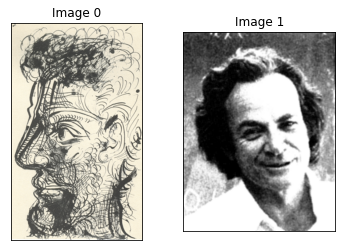

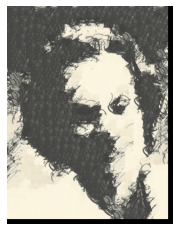

In [141]:
# load/process appropriate input texture and guidance images
sample_text = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(sample_text), cv2.COLOR_BGR2RGB)
sample_guide = 'samples/feynman.tiff' 
guidance_img = cv2.cvtColor(cv2.imread(sample_guide), cv2.COLOR_BGR2RGB)

patch_size = 25
overlap = 11
tol = 10
alpha = 0.3

res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

showImg([texture_img, guidance_img])
showImg(res)


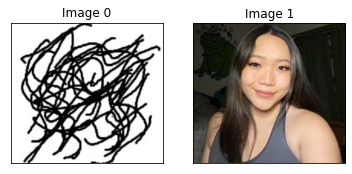

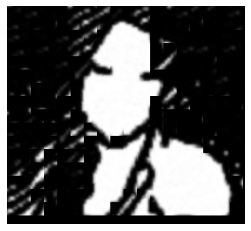

In [146]:
my_sample_text = 'samples/lines.jpg' 
my_texture_img = cv2.cvtColor(cv2.imread(my_sample_text), cv2.COLOR_BGR2RGB)
my_sample_guide = 'samples/Alex.jpg' 
my_guidance_img = cv2.cvtColor(cv2.imread(my_sample_guide), cv2.COLOR_BGR2RGB)

patch_size = 25
overlap = 11
tol = 10
alpha = 0.7

myRes = texture_transfer(my_texture_img, patch_size, overlap, tol, my_guidance_img, alpha)


showImg([my_texture_img, my_guidance_img])
showImg(myRes)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).